## Package Installation

In [106]:
# !pip install tweepy
# !pip install textblob
# !pip install flask
# !pip install wordcloud
# !pip install -U gensim

NameError: name 'tensorflow' is not defined

## Test Data
The dataset can be downloaded from the below link.
http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

By looking at the description of the dataset from the link, the information on each field can be found. <br>
0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)  <br>
1 - the id of the tweet (2087)  <br>
2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)  <br>
3 - the query (lyx). If there is no query, then this value is NO_QUERY.  <br>
4 - the user that tweeted (robotickilldozr)  <br>
5 - the text of the tweet (Lyx is cool)  <br>

In [113]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
plt.style.use('fivethirtyeight')
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.python.ops.math_ops import reduce_prod


[nltk_data] Downloading package punkt to /Users/maushamee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maushamee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/maushamee/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [117]:
!pip install tensorflow
import tensorflow as tf
print(tf.version.VERSION)

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow
2.5.0


In [2]:
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("/Users/maushamee/Documents/MSC/PROMO6/Training_DataSet/trainingandtestdata/training.1600000.processed.noemoticon.csv",header=None, names=cols,encoding = 'ISO-8859-1')
# above line will be different depending on where you saved your data, and your file name
print(df.head())
print(df.sentiment.value_counts())

   sentiment          id                          date query_string  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009     NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009     NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009     NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009     NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009     NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
0    800000
4    800000
Name: sentiment, dtype: int64


In [3]:
print(df.info())
print(df.sentiment.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   sentiment     1600000 non-null  int64 
 1   id            1600000 non-null  int64 
 2   date          1600000 non-null  object
 3   query_string  1600000 non-null  object
 4   user          1600000 non-null  object
 5   text          1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None
0    800000
4    800000
Name: sentiment, dtype: int64


### removing columns which are not required

In [4]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)

### Check the index of the positive and negative tweets

In [5]:

print(df[df.sentiment == 0].index)
print(df[df.sentiment == 4].index)
df.sentiment.value_counts()

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            799990, 799991, 799992, 799993, 799994, 799995, 799996, 799997,
            799998, 799999],
           dtype='int64', length=800000)
Int64Index([ 800000,  800001,  800002,  800003,  800004,  800005,  800006,
             800007,  800008,  800009,
            ...
            1599990, 1599991, 1599992, 1599993, 1599994, 1599995, 1599996,
            1599997, 1599998, 1599999],
           dtype='int64', length=800000)


0    800000
4    800000
Name: sentiment, dtype: int64

### change the class value of 4 (positive) to 1

## Data Cleaning

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:negative, 1:positive',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


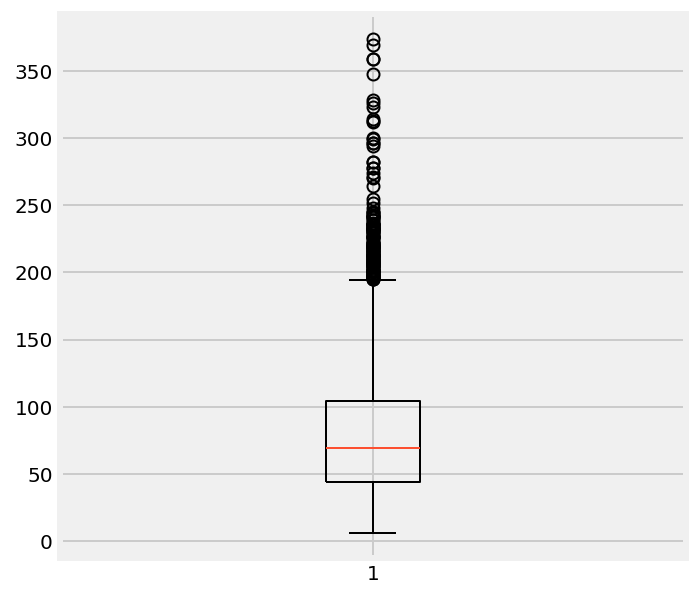

In [6]:
df['pre_clean_len'] = [len(t) for t in df.text]
from pprint import pprint
data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}
pprint(data_dict)

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

### Need to clean tweets as some show >140 lendth
#### HTML Decoding

In [7]:
print(df.text[279])
example1 = BeautifulSoup(df.text[279], 'lxml')
print(example1.get_text())

Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. 
Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


#### ‘@’mention

In [8]:
print(df.text[343])
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down 


' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

#### removing URL links

In [9]:
print(df.text[0])
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

#### UTF-8 BOM (Byte Order Mark)

In [10]:
print(df.text[226]) # example to show some strange characters
df.text[226].encode('latin-1').decode('utf-8-sig')


Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers 


'Tuesday�ll start with reflection �n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

#### hastag and numbers
##### only removing the '#'

In [11]:
print(df.text[175])
re.sub("[^a-zA-Z]", " ", df.text[175])

@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail


' machineplay I m so sorry you re having to go through this  Again    therapyfail'

### Combine the above Data Cleaning

In [12]:

tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    clean_repeat = re.sub(r'(.)1+', r'1', letters_only)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(clean_repeat) if len(x) > 1]
    return (" ".join(words)).strip()

In [13]:

df = pd.read_csv("/Users/maushamee/Documents/MSC/PROMO6/Training_DataSet/trainingandtestdata/training.1600000.processed.noemoticon.csv",header=None,
                 usecols=[0,5],names=['sentiment','text'],encoding = 'ISO-8859-1')
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
print(df.head())

print("Cleaning the tweets...\n")
clean_tweet_texts = []
for i in range(0,len(df)):
    if( (i+1)%100000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, len(df) ))                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))  

   sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....
Cleaning the tweets...

Tweets 100000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 300000 of 1600000 has been processed
Tweets 400000 of 1600000 has been processed
Tweets 500000 of 1600000 has been processed
Tweets 600000 of 1600000 has been processed
Tweets 700000 of 1600000 has been processed
Tweets 800000 of 1600000 has been processed
Tweets 900000 of 1600000 has been processed
Tweets 1000000 of 1600000 has been processed
Tweets 1100000 of 1600000 has been processed
Tweets 1200000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1400000 o

### Save the cleaned tweets data set

In [14]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
print(clean_df.head())
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

                                                text  target
0  awww that bummer you shoulda got david carr of...       0
1  is upset that he can not update his facebook b...       0
2  dived many times for the ball managed to save ...       0
3     my whole body feels itchy and like its on fire       0
4  no it not behaving at all mad why am here beca...       0


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [15]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596522 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [16]:
print(my_df[my_df.isnull().any(axis=1)].head())
np.sum(my_df.isnull().any(axis=1))

     text  target
208   NaN       0
249   NaN       0
398   NaN       0
430   NaN       0
1011  NaN       0


3478

### Remove the null text entries in the data set

In [17]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
print(my_df.info())
my_df['text'].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596522 entries, 0 to 1596521
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596522 non-null  object
 1   target  1596522 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB
None


0    awww that bummer you shoulda got david carr of...
1    is upset that he can not update his facebook b...
2    dived many times for the ball managed to save ...
3       my whole body feels itchy and like its on fire
4    no it not behaving at all mad why am here beca...
Name: text, dtype: object

### word cloud

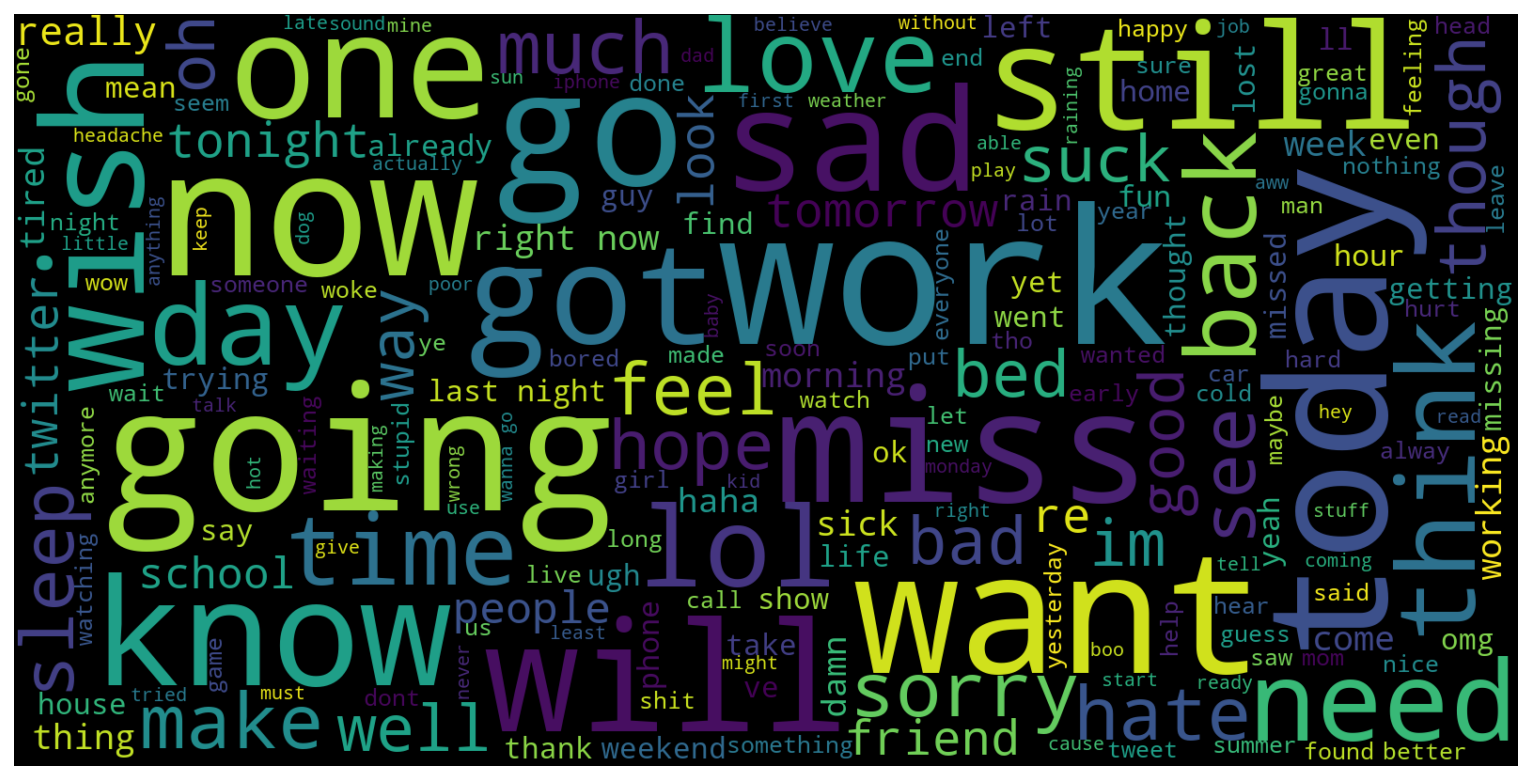

In [18]:
# negative work cloud

neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

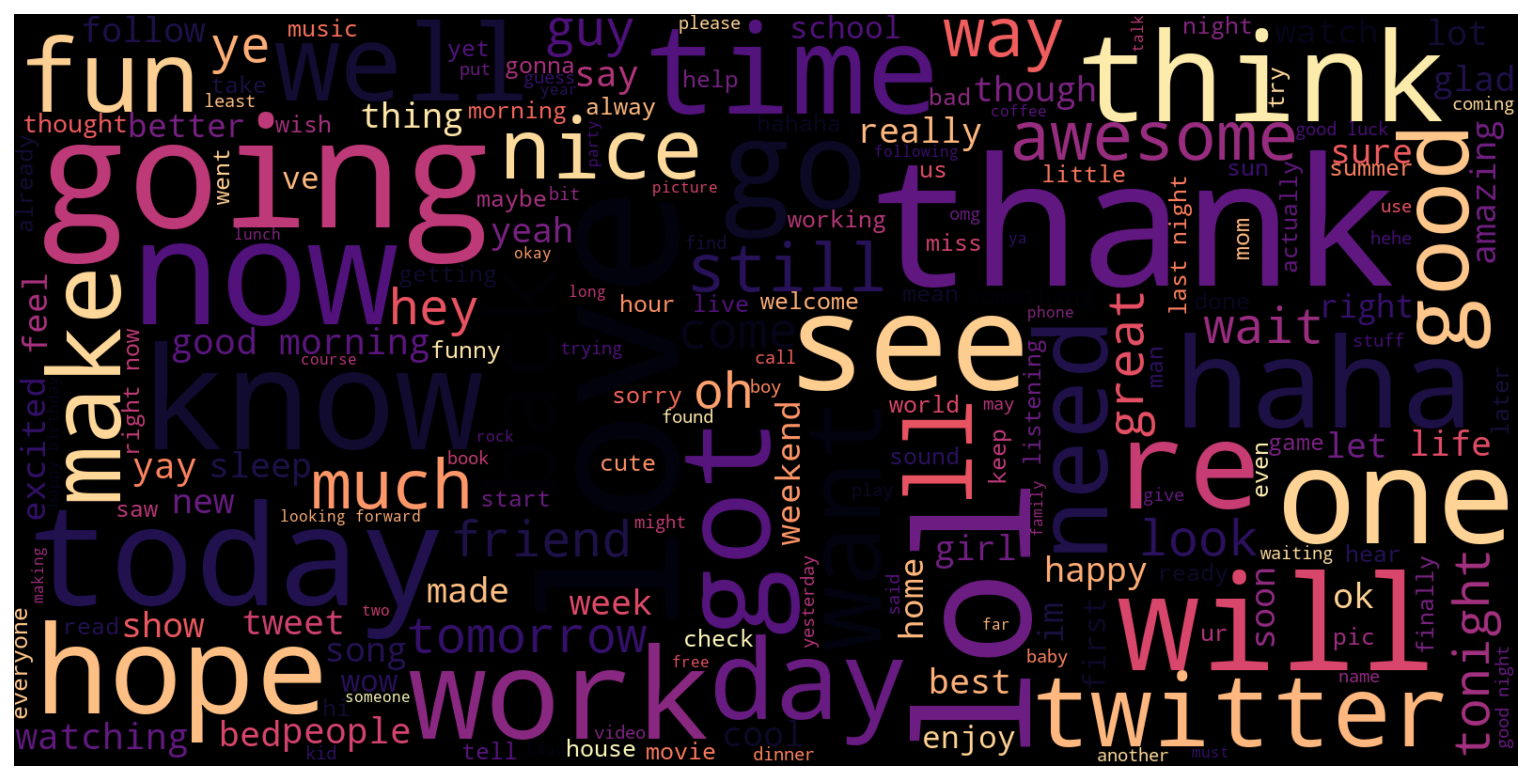

In [19]:
# positive word cloud

pos_tweets = my_df[my_df.target == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Applying Stemming

In [20]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
my_df['text']= my_df['text'].apply(lambda x: stemming_on_text(x))
my_df['text'].head()

0    awww that bummer you shoulda got david carr of...
1    is upset that he can not update his facebook b...
2    dived many times for the ball managed to save ...
3       my whole body feels itchy and like its on fire
4    no it not behaving at all mad why am here beca...
Name: text, dtype: object

### Applying Lemmatizer

In [21]:
#nltk.download('wordnet')
#nltk.download('omw-1.4')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
my_df['text'] = my_df['text'].apply(lambda x: lemmatizer_on_text(x))
my_df['text'].head()

0    awww that bummer you shoulda got david carr of...
1    is upset that he can not update his facebook b...
2    dived many times for the ball managed to save ...
3       my whole body feels itchy and like its on fire
4    no it not behaving at all mad why am here beca...
Name: text, dtype: object

## Train and Test

### Separating input feature and label

In [22]:
x = my_df.text
y = my_df.target

### Splitting our data into Train and Test Subset

In [23]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, utils, optimizers, preprocessing
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.05, random_state=SEED)


Init Plugin
Init Graph Optimizer
Init Kernel


In [24]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))


Train set has total 1516695 entries with 50.01% negative, 49.99% positive
Test set has total 79827 entries with 49.95% negative, 50.05% positive


### TF-IDF Vectorizer

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(x_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


### Transform using TF-IDF Vectorizer

In [26]:
x_train = vectoriser.transform(x_train)
x_test  = vectoriser.transform(x_test)

## Model

### Evaluation function

In [27]:
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(x_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg ','False Pos ', 'False Neg ','True Pos ']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)


### Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(x_train, y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

#### Accuracy Score and Confusion Matrix with Plot

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     39871
           1       0.82      0.83      0.83     39956

    accuracy                           0.83     79827
   macro avg       0.83      0.83      0.83     79827
weighted avg       0.83      0.83      0.83     79827



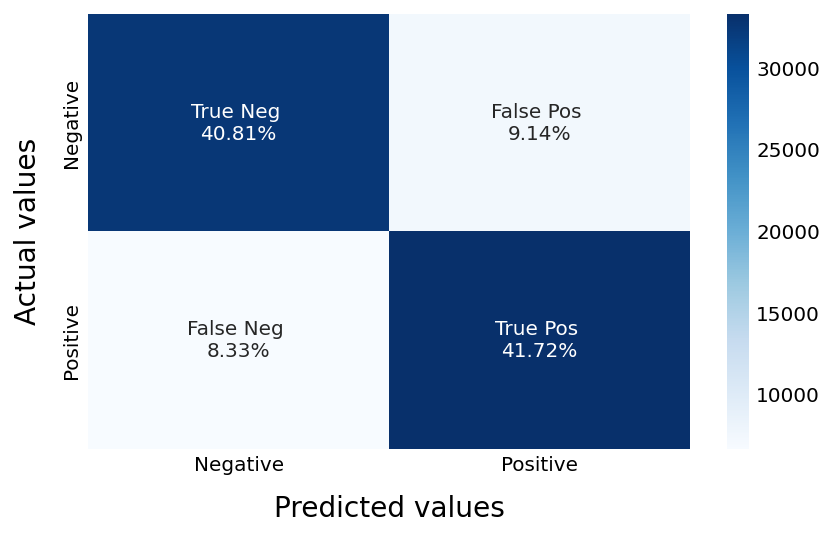

In [29]:
#from sklearn.metrics import confusion_matrix, classification_report
#import seaborn as sns

model_Evaluate(LRmodel)
y_pred_lg = LRmodel.predict(x_test)

#### ROC-AUC Curve

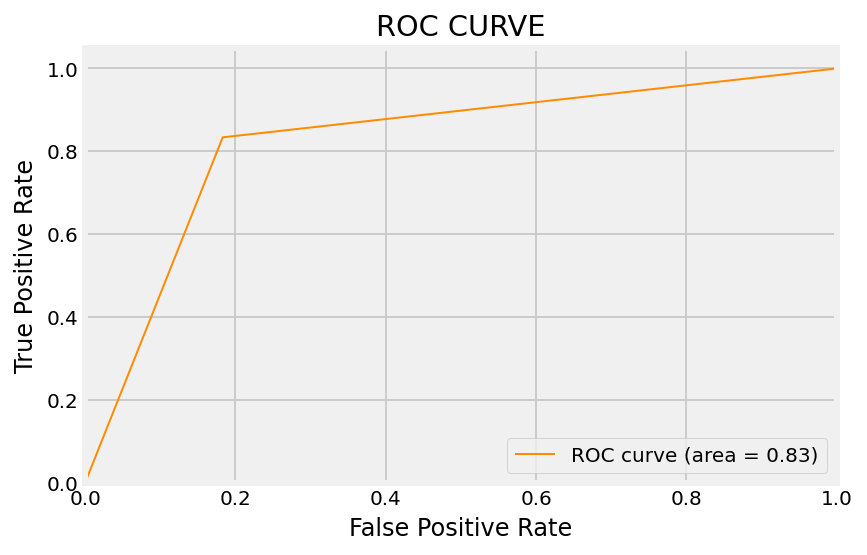

In [30]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lg)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Naive Bayes

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     39871
           1       0.79      0.81      0.80     39956

    accuracy                           0.80     79827
   macro avg       0.80      0.80      0.80     79827
weighted avg       0.80      0.80      0.80     79827



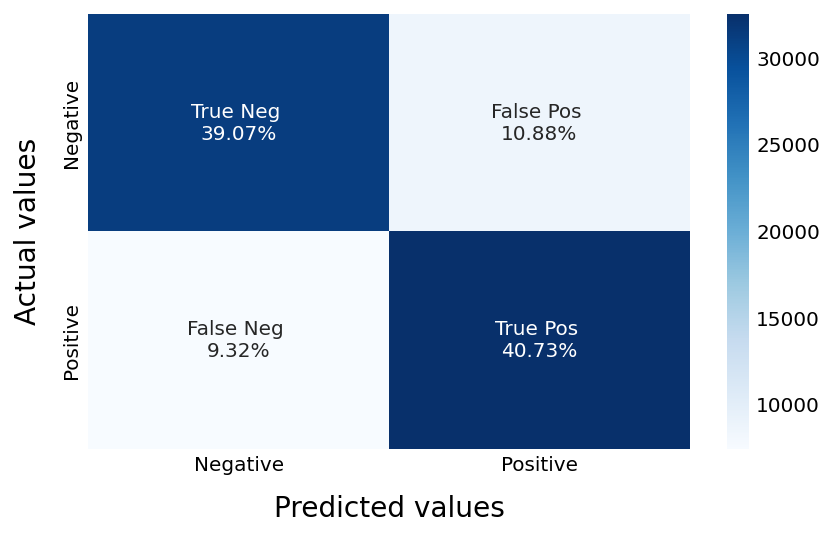

In [31]:
from sklearn.naive_bayes import BernoulliNB
NBmodel = BernoulliNB()
NBmodel.fit(x_train, y_train)
model_Evaluate(NBmodel)
y_pred_NB = NBmodel.predict(x_test)

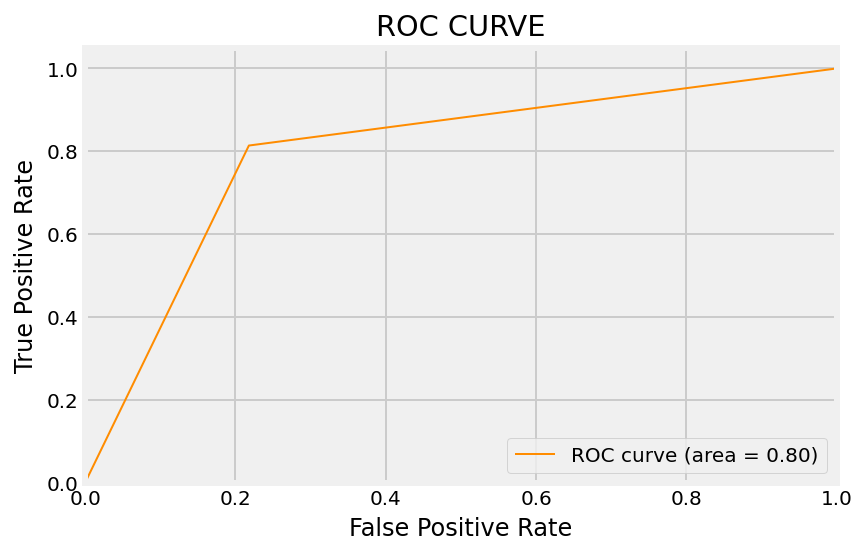

In [32]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_NB)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### SVC

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     39871
           1       0.81      0.82      0.82     39956

    accuracy                           0.82     79827
   macro avg       0.82      0.82      0.82     79827
weighted avg       0.82      0.82      0.82     79827



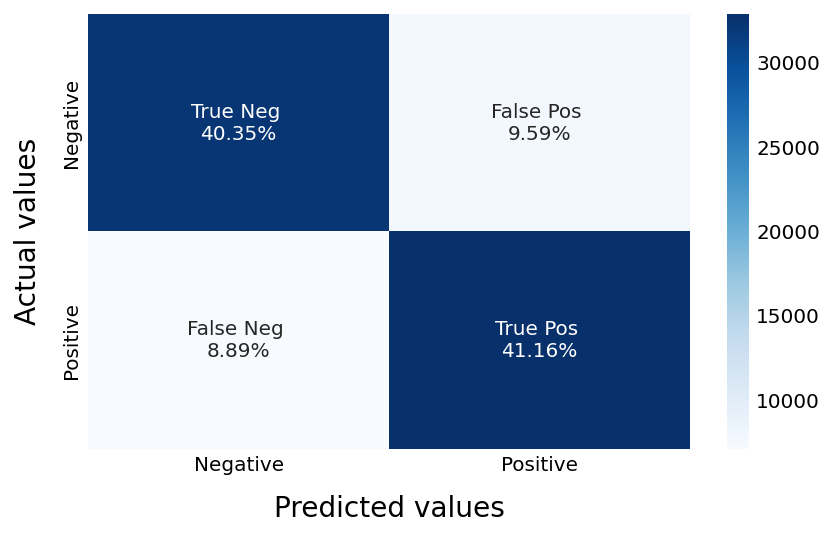

In [33]:
from sklearn.svm import LinearSVC
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)
model_Evaluate(SVCmodel)
y_pred_SVC = SVCmodel.predict(x_test)

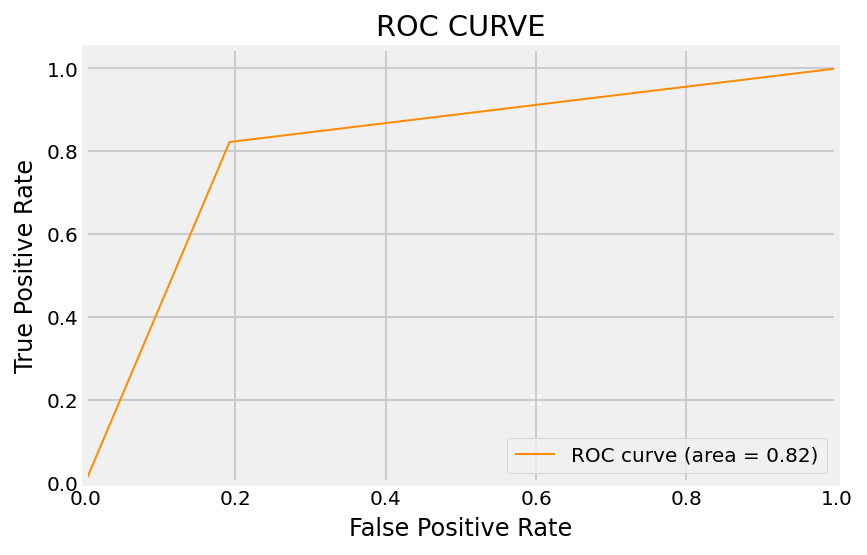

In [35]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_SVC)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### CNN
https://www.kaggle.com/code/imabhilash/twitter-sentiment-analysis-using-cnn-deeplearning

In [64]:
x = my_df.text
y = my_df.target

SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.05, random_state=SEED)

print('X Train Shape: ',x_train.shape)
print('X Test Shape: ',x_test.shape)
print('Y Train Shape: ',y_train.shape)
print('Y Test Shape: ',y_test.shape)

X Train Shape:  (1516695,)
X Test Shape:  (79827,)
Y Train Shape:  (1516695,)
Y Test Shape:  (79827,)


In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_words=10000
tokenizer=Tokenizer(max_words)
tokenizer.fit_on_texts(x_train)
sequence_train=tokenizer.texts_to_sequences(x_train)
sequence_test=tokenizer.texts_to_sequences(x_test)

In [66]:
word2vec=tokenizer.word_index
V=len(word2vec)
print('dataset has %s number of independent tokens' %V)

dataset has 263089 number of independent tokens


In [67]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_train=pad_sequences(sequence_train)
data_train.shape

(1516695, 40)

In [68]:
T=data_train.shape[1]
data_test=pad_sequences(sequence_test,maxlen=T)
data_test.shape

(79827, 40)

In [69]:
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
from tensorflow.keras.models import Model

D=20
i=Input((T,))
x=Embedding(V+1,D)(i)
x=Conv1D(32,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(5,activation='softmax')(x)
model=Model(i,x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 40, 20)            5261800   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 38, 32)            1952      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 128)            24704 

#### Training the model

In [71]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_senti=model.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=5,batch_size=100)

Epoch 1/5


2022-12-11 11:16:45.761984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15167/15167 [==============================] - ETA: 0s - loss: 0.5891 - accuracy: 0.6741

2022-12-11 11:21:58.345412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15167/15167 [==============================] - 316s 21ms/step - loss: 0.5891 - accuracy: 0.6741 - val_loss: 0.5766 - val_accuracy: 0.6853
Epoch 2/5
15167/15167 [==============================] - 314s 21ms/step - loss: 0.5677 - accuracy: 0.6908 - val_loss: 0.5725 - val_accuracy: 0.6868
Epoch 3/5
15167/15167 [==============================] - 461s 30ms/step - loss: 0.5578 - accuracy: 0.6983 - val_loss: 0.5741 - val_accuracy: 0.6881
Epoch 4/5
15167/15167 [==============================] - 327s 22ms/step - loss: 0.5500 - accuracy: 0.7034 - val_loss: 0.5744 - val_accuracy: 0.6870
Epoch 5/5
15167/15167 [==============================] - 333s 22ms/step - loss: 0.5433 - accuracy: 0.7078 - val_loss: 0.5784 - val_accuracy: 0.6853


In [72]:
y_pred=model.predict(data_test)
y_pred

2022-12-11 11:46:24.065289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[2.13252813e-01, 7.86747217e-01, 1.18488115e-23, 7.36614647e-24,
        1.49024850e-23],
       [2.45249361e-01, 7.54750669e-01, 3.97675351e-16, 2.89059628e-16,
        3.54010962e-16],
       [4.45378274e-01, 5.54621816e-01, 1.16452101e-08, 1.15298091e-08,
        1.20646879e-08],
       ...,
       [4.45378274e-01, 5.54621816e-01, 1.16452101e-08, 1.15298091e-08,
        1.20646879e-08],
       [4.45378274e-01, 5.54621816e-01, 1.16452101e-08, 1.15298091e-08,
        1.20646879e-08],
       [4.45378274e-01, 5.54621816e-01, 1.16452101e-08, 1.15298091e-08,
        1.20646879e-08]], dtype=float32)

In [75]:
y_pred=np.argmax(y_pred,axis=1)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

Text(17.060000000000002, 0.5, 'y_pred')

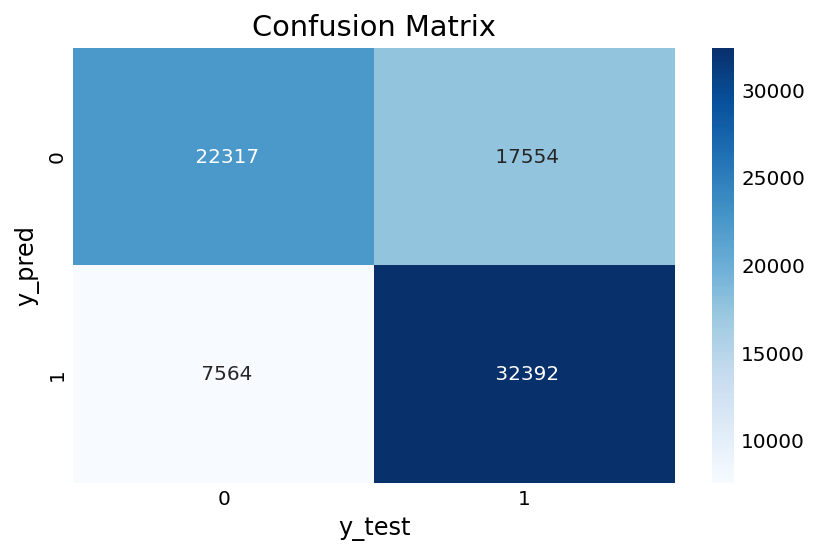

In [76]:
cm=confusion_matrix(y_test,y_pred)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

In [77]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.56      0.64     39871
           1       0.65      0.81      0.72     39956

    accuracy                           0.69     79827
   macro avg       0.70      0.69      0.68     79827
weighted avg       0.70      0.69      0.68     79827



### CNN
https://github.com/tthustla/twitter_sentiment_analysis_part11/blob/master/Capstone_part11.ipynb

In [133]:
x = my_df.text
y = my_df.target

SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)


In [135]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))


Train set has total 1564591 entries with 50.00% negative, 50.00% positive
Validation set has total 15965 entries with 50.00% negative, 50.00% positive
Test set has total 15966 entries with 50.39% negative, 49.61% positive


In [136]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

In [137]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [138]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [140]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, vector_size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])


100%|██████████| 1596522/1596522 [00:00<00:00, 2633837.96it/s]


In [141]:
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 1596522/1596522 [00:00<00:00, 5174355.17it/s]


In [143]:
model_ug_sg = Word2Vec(sg=1, vector_size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 1596522/1596522 [00:00<00:00, 4443498.30it/s]


In [144]:
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 1596522/1596522 [00:00<00:00, 5052334.61it/s]


In [145]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

#### Preparation for Convolutional Neural Network

In [148]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')
print(len(model_ug_cbow.wv.key_to_index.keys()))

embeddings_index = {}
for w in model_ug_cbow.wv.key_to_index.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

109094
Found 109094 word vectors.


In [228]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [151]:
print(len(tokenizer.word_index))
for x in x_train[:5]:
    print(x)

268091
isplayer has died sorry
hey your not following me yet how are you hun miss you already xxx
sleep cheerleading jakes coming fishing and hes spending the night
you could indeed think was about alexis age when saw terminator made for tv
it raining


In [152]:
sequences[:5]

[[4989, 90, 582, 115],
 [141, 39, 7, 398, 14, 200, 63, 33, 6, 1011, 83, 6, 184, 683],
 [108, 10622, 16148, 255, 2950, 5, 1267, 1070, 2, 64],
 [6, 112, 995, 71, 23, 55, 7794, 1456, 76, 269, 2121, 195, 10, 389],
 [4, 462]]

In [154]:
length = []
for x in x_train:
    length.append(len(x.split()))
print(max(length))

40


In [155]:
x_train_seq = pad_sequences(sequences, maxlen=45)
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (1564591, 45)


In [156]:
x_train_seq[:5]


array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,  4989,    90,   582,   115],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   141,    39,     7,   398,    14,
          200,    63,    33,     6,  1011,    83,     6,   184,   683],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,   108,
    

In [157]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=45)

In [158]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [159]:
np.array_equal(embedding_matrix[6] ,embeddings_index.get('you'))

True

#### Model

In [199]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential

structure_test = Sequential()
e = Embedding(100000, 200, input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 45, 200)           20000000  
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 44, 100)           40100     
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [162]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.add(GlobalMaxPooling1D())
structure_test.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 45, 200)           20000000  
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 44, 100)           40100     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [163]:
model_cnn_01 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=False)
model_cnn_01.add(e)
model_cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_01.add(GlobalMaxPooling1D())
model_cnn_01.add(Dense(256, activation='relu'))
model_cnn_01.add(Dense(1, activation='sigmoid'))
model_cnn_01.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_01.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)


Epoch 1/5


2022-12-11 14:06:11.842099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-11 14:11:08.217198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


48894/48894 - 298s - loss: 0.4179 - accuracy: 0.8071 - val_loss: 0.4003 - val_accuracy: 0.8192
Epoch 2/5
48894/48894 - 290s - loss: 0.3978 - accuracy: 0.8188 - val_loss: 0.3923 - val_accuracy: 0.8217
Epoch 3/5
48894/48894 - 885s - loss: 0.3909 - accuracy: 0.8229 - val_loss: 0.3887 - val_accuracy: 0.8224
Epoch 4/5
48894/48894 - 397s - loss: 0.3871 - accuracy: 0.8250 - val_loss: 0.3859 - val_accuracy: 0.8252
Epoch 5/5
48894/48894 - 297s - loss: 0.3843 - accuracy: 0.8267 - val_loss: 0.3878 - val_accuracy: 0.8240


In [167]:
from tensorflow.keras.layers import Input, Dense, concatenate, Activation
from tensorflow.keras.models import Model

tweet_input = Input(shape=(45,), dtype='int32')

tweet_encoder = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 45, 200)      20000000    input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 44, 100)      40100       embedding_24[0][0]               
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 43, 100)      60100       embedding_24[0][0]               
____________________________________________________________________________________________

In [170]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
                     validation_data=(x_val_seq, y_validation), callbacks = [checkpoint])


Epoch 1/5
48894/48894 [==============================] - 3214s 66ms/step - loss: 0.3607 - accuracy: 0.8413 - val_loss: 0.3736 - val_accuracy: 0.8340

Epoch 00001: val_accuracy improved from -inf to 0.83401, saving model to CNN_best_weights.01-0.8340.hdf5
Epoch 2/5
48894/48894 [==============================] - 3706s 76ms/step - loss: 0.3309 - accuracy: 0.8568 - val_loss: 0.3769 - val_accuracy: 0.8324

Epoch 00002: val_accuracy did not improve from 0.83401
Epoch 3/5
48894/48894 [==============================] - 3129s 64ms/step - loss: 0.2989 - accuracy: 0.8732 - val_loss: 0.3950 - val_accuracy: 0.8301

Epoch 00003: val_accuracy did not improve from 0.83401
Epoch 4/5
48894/48894 [==============================] - 3162s 65ms/step - loss: 0.2665 - accuracy: 0.8886 - val_loss: 0.4069 - val_accuracy: 0.8225

Epoch 00004: val_accuracy did not improve from 0.83401
Epoch 5/5
48894/48894 [==============================] - 3399s 70ms/step - loss: 0.2363 - accuracy: 0.9024 - val_loss: 0.4440 - va

In [171]:
from tensorflow.keras.models import load_model
loaded_CNN_model = load_model('CNN_best_weights.01-0.8340.hdf5')
loaded_CNN_model.evaluate(x=x_val_seq, y=y_validation)

  6/499 [..............................] - ETA: 5s - loss: 0.4251 - accuracy: 0.8021  

2022-12-11 21:30:52.696120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


499/499 [==============================] - 3s 7ms/step - loss: 0.3736 - accuracy: 0.8340


[0.3736262321472168, 0.834011971950531]

### Final Model Evaluation (test data set)

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
tvec.fit(x_train)

TfidfVectorizer(max_features=100000, ngram_range=(1, 3))

In [173]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [175]:
lr_with_tfidf = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
lr_with_tfidf.fit(x_train_tfidf,y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

In [176]:
lr_with_tfidf.score(x_test_tfidf,y_test)

0.8278842540398347

In [177]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

In [178]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=45)

In [179]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

499/499 [==============================] - 4s 7ms/step - loss: 0.3740 - accuracy: 0.8326


[0.37396475672721863, 0.8326443433761597]

In [180]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

2022-12-11 21:38:17.635055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


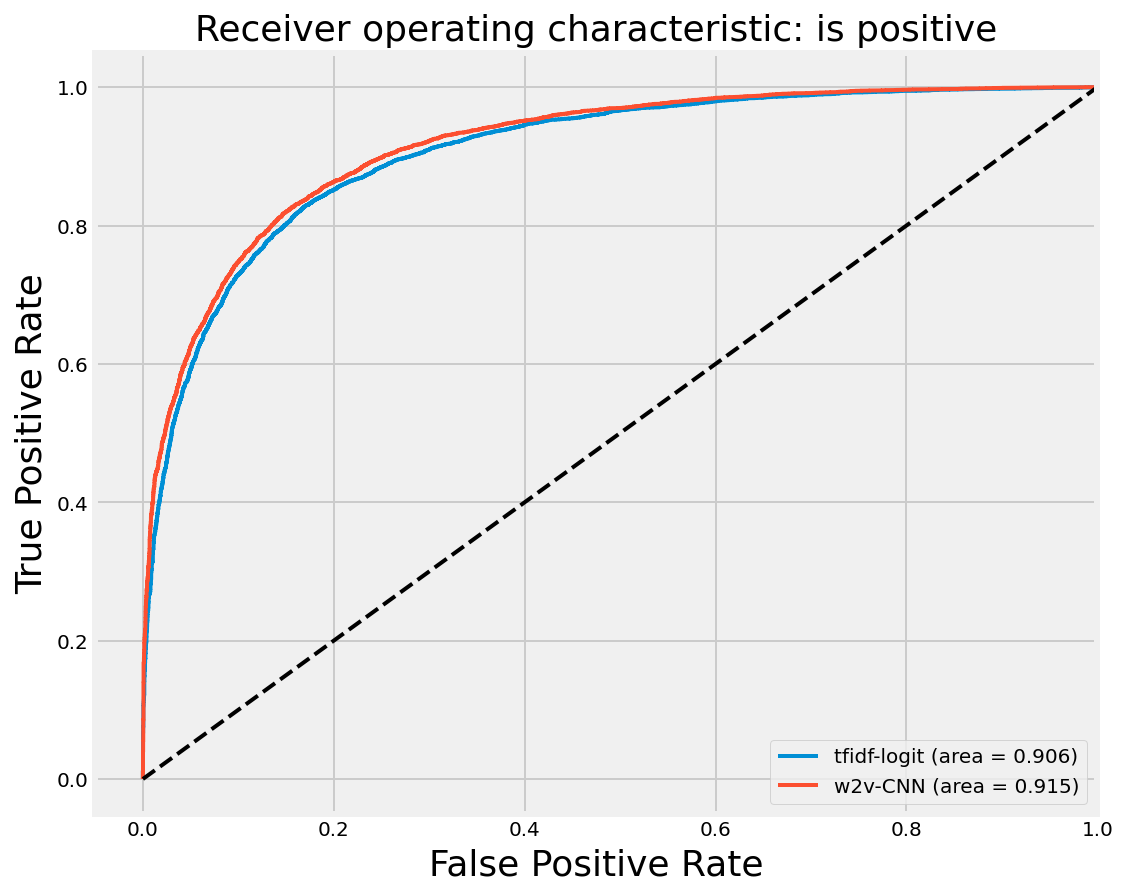

In [181]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:,1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# FINAL Result 
https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-11-cnn-word2vec-41f5e28eda74


Model Tf-Idf + logistic regression	:test set accuracy -> 82.79% ROC AUC ->0.91

Model Word2Vec + CNN                : test set accuracy -> 83.26% ROC AUC ->0.92

In [245]:
x_test = 'i am happy'
sequences_test = tokenizer.texts_to_sequences([x_test])
print(sequences_test)
x_test_seq = pad_sequences(sequences_test, maxlen=45)
loaded_CNN_model.predict(x_test_seq).round()

[[49, 111]]


array([[1.]], dtype=float32)

### Saving the tokenizer

In [250]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
